### Dependencies

In [40]:
## Its possible that you will need these installations
!pip install openpyxl
#!pip install tensorflow
#!pip install tensorflow_probability
!pip install statsmodels
!pip install arspy


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Files

In [41]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from arspy.ars import adaptive_rejection_sampling

### Convert Excel --> CSV

In [42]:
# Read Excel file
excel_file = pd.read_excel('simulation_data.xlsx')

# Convert to CSV
csv_file = 'simulation_data.csv'
excel_file.to_csv(csv_file, index=False)

print(f"Excel file converted to CSV: {csv_file}")

Excel file converted to CSV: simulation_data.csv


### Preview the Data

In [43]:
df = pd.read_csv(csv_file)
print(df)

    Observations  Obesity Hypertension Alcohol Consumption per Day
0             38      Low           No                    0 Drinks
1             34      Low           No                  1-2 Drinks
2             31      Low           No                  3-5 Drinks
3             22      Low           No                   6+ Drinks
4              5      Low          Yes                    0 Drinks
5              9      Low          Yes                  1-2 Drinks
6              8      Low          Yes                  3-5 Drinks
7             10      Low          Yes                   6+ Drinks
8             31  Average           No                    0 Drinks
9             23  Average           No                  1-2 Drinks
10            35  Average           No                  3-5 Drinks
11            30  Average           No                   6+ Drinks
12             6  Average          Yes                    0 Drinks
13             9  Average          Yes                  1-2 Dr

### Calculate the Beta_Hat's and the Covariance Matrix

In [44]:
# Perform one-hot encoding on relevant columns
one_hot_encoded_data = pd.get_dummies(df, columns=['Obesity', 'Hypertension', 'Alcohol Consumption per Day'])

# Select the desired columns for the result
result_columns = ['Obesity_Average', 'Obesity_High', 'Hypertension_Yes',
                  'Alcohol Consumption per Day_1-2 Drinks', 'Alcohol Consumption per Day_3-5 Drinks', 'Alcohol Consumption per Day_6+ Drinks']
result_data = one_hot_encoded_data[result_columns]

# Convert the result dataframe to a numpy array
matrix = result_data.to_numpy()

# Convert True and False to 1 and 0
matrix = matrix.astype(int)

# Add an intercept column of ones
intercept_column = np.ones((matrix.shape[0], 1), dtype=int)
matrix = np.hstack((intercept_column, matrix))

# Print the matrix with clear 1s and 0s
np.set_printoptions(edgeitems=3, formatter={'int': '{:3d}'.format})
print(matrix)

# observations
y = df['Observations']

[[  1   0   0   0   0   0   0]
 [  1   0   0   0   1   0   0]
 [  1   0   0   0   0   1   0]
 [  1   0   0   0   0   0   1]
 [  1   0   0   1   0   0   0]
 [  1   0   0   1   1   0   0]
 [  1   0   0   1   0   1   0]
 [  1   0   0   1   0   0   1]
 [  1   1   0   0   0   0   0]
 [  1   1   0   0   1   0   0]
 [  1   1   0   0   0   1   0]
 [  1   1   0   0   0   0   1]
 [  1   1   0   1   0   0   0]
 [  1   1   0   1   1   0   0]
 [  1   1   0   1   0   1   0]
 [  1   1   0   1   0   0   1]
 [  1   0   1   0   0   0   0]
 [  1   0   1   0   1   0   0]
 [  1   0   1   0   0   1   0]
 [  1   0   1   0   0   0   1]
 [  1   0   1   1   0   0   0]
 [  1   0   1   1   1   0   0]
 [  1   0   1   1   0   1   0]
 [  1   0   1   1   0   0   1]]


In [45]:
poisson_model = sm.GLM(y, matrix, family=sm.families.Poisson())  # Fit the Poisson GLM
results = poisson_model.fit()

beta_hat = results.params
cov_matrix_hat = results.cov_params()

print(beta_hat)
print(cov_matrix_hat.shape)

const    3.289832
x1       0.012658
x2       0.049700
x3      -0.982736
x4      -0.008889
x5       0.155414
x6       0.092894
dtype: float64
(7, 7)


### Gibbs Sampling

In [46]:
def conditional_sampler(sampling_index, current_x, mean, obs):
    cond_indices = [i for i in range(len(mean)) if i != sampling_index]
    new_x = np.copy(current_x)
    temp = np.zeros((matrix.shape[0], 1))
    for i in range(matrix.shape[0]):
        temp[i] = np.sum(current_x[cond_indices] @ matrix[i][cond_indices])

    formula = lambda x: sum(-np.exp(matrix[i][sampling_index]*x + temp[i]) + obs[i] * (matrix[i][sampling_index]*x + temp[i]) for i in range(matrix.shape[0]))

    domain = (float("-inf"), float("inf"))
    a = -4
    b = 4

    new_x[sampling_index] = adaptive_rejection_sampling(formula, a, b, domain, 1)[0]
    return new_x

In [47]:
def gibbs_sampler(initial_point, num_samples, mean, burn_in, thinning, obs):

    point = np.array(initial_point)
    samples = np.zeros((num_samples, 7))  # sampled points

    sample_counter = 0
    counter = 0
    while sample_counter < num_samples:
        for i in range(len(mean)):
            point = conditional_sampler(i, point, mean, obs)

        # Save the sample using burn_in and thinning
        if counter > burn_in and (counter-burn_in) % thinning == 0:
            samples[sample_counter] = point
            sample_counter += 1

        counter += 1

    return samples

In [48]:
mean = np.array(beta_hat).T
initial_point = [2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
num_samples = 500
burn_in = 500
thinning = 1
observations = np.array(y)

samples = gibbs_sampler(initial_point, num_samples, mean, burn_in, thinning, observations)
sample_mean = np.mean(samples, axis = 0)
sample_std = np.std(samples, axis = 0)

print("The simulated mean is: {}".format(np.around(sample_mean, decimals=2)))

print("The simulated standard deviation is: {}".format(np.around(sample_std, decimals=2)))

C:\Users\Platon\AppData\Local\Programs\Python\Python310\lib\site-packages\arspy\hull.py:204: RuntimeWarning: divide by zero encountered in log
  return -log(abs(m)) + log(abs(exp(m * r + b - M) - exp(m * l + b - M))) + M


The simulated mean is: [ 3.29  0.01  0.05 -0.99 -0.01  0.15  0.09]
The simulated standard deviation is: [0.11 0.11 0.11 0.1  0.13 0.13 0.12]


### The Histograms of Gibbs for each Beta_Hat

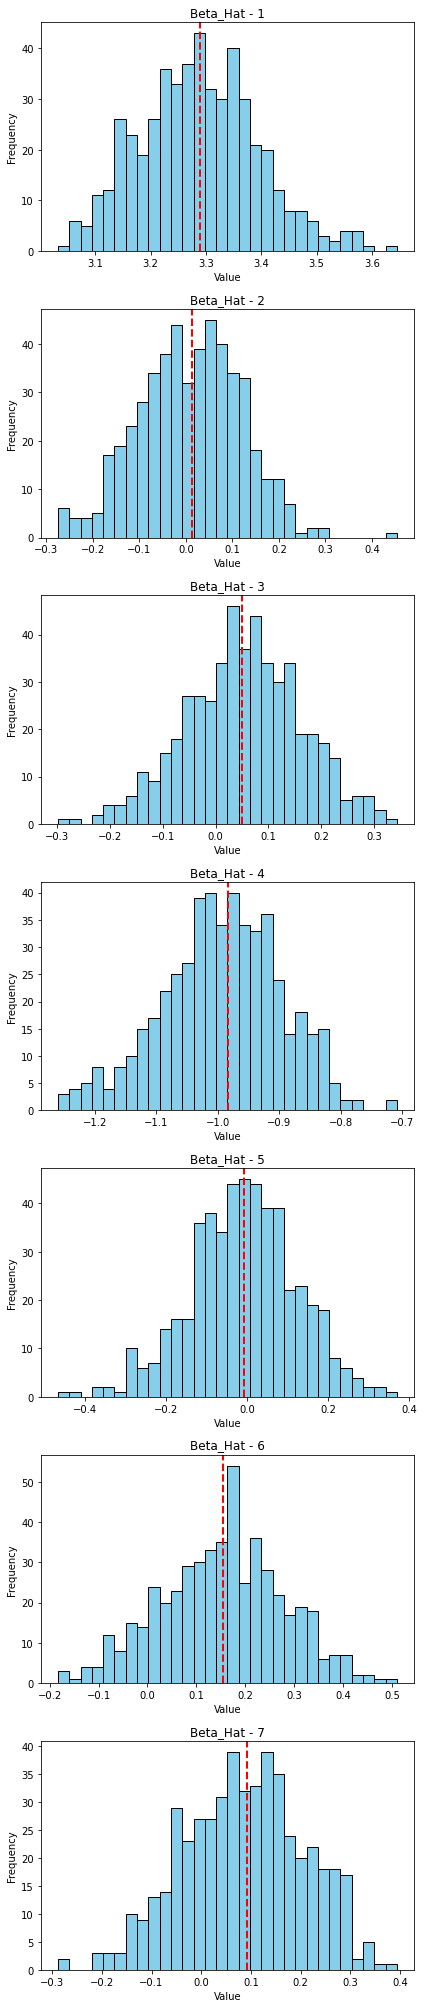

In [49]:
# Get the number of dimensions
num_dimensions = samples.shape[1]

# Create a figure with subplots for each dimension
fig, axes = plt.subplots(nrows=num_dimensions, ncols=1, figsize=(6, num_dimensions*4))

# Iterate over each dimension
for i in range(num_dimensions):
    # Get the samples for the current dimension
    dimension_samples = samples[:, i]

    # Plot the histogram
    axes[i].hist(dimension_samples, bins=30, color='skyblue', edgecolor='black')

    # Add a vertical line for the true value
    axes[i].axvline(x=beta_hat[i], color='red', linestyle='--', linewidth=2)

    # Set the plot title and labels
    axes[i].set_title(f'Beta_Hat - {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Gibbs Convergence Chains

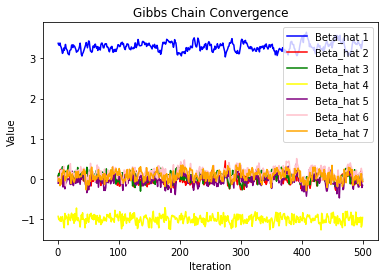

In [50]:
# Generate an array of iteration numbers
iterations = np.arange(1, num_samples + 1)

# Plot the convergence of the chain
plt.plot(iterations, samples[:, 0], color='blue', label='Beta_hat 1')
plt.plot(iterations, samples[:, 1], color='red', label='Beta_hat 2')
plt.plot(iterations, samples[:, 2], color='green', label='Beta_hat 3')
plt.plot(iterations, samples[:, 3], color='yellow', label='Beta_hat 4')
plt.plot(iterations, samples[:, 4], color='purple', label='Beta_hat 5')
plt.plot(iterations, samples[:, 5], color='pink', label='Beta_hat 6')
plt.plot(iterations, samples[:, 6], color='orange', label='Beta_hat 7')
# Add more lines for additional dimensions

# Set the plot title and labels
plt.title('Gibbs Chain Convergence')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### The Autocorrelation Chains

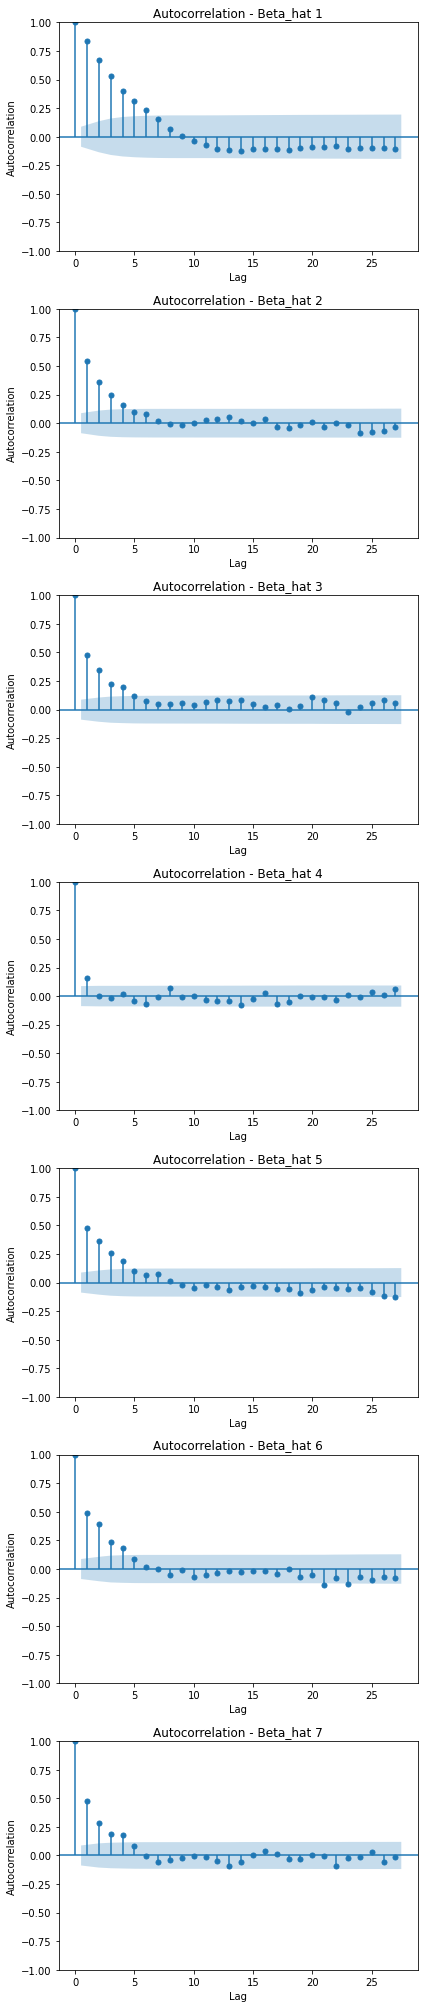

In [52]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation for each dimension
fig, axes = plt.subplots(nrows=num_dimensions, ncols=1, figsize=(6, num_dimensions*4))

# Iterate over each dimension
for i in range(num_dimensions):
    # Get the samples for the current dimension
    dimension_samples = samples[:, i]

    # Plot the autocorrelation
    plot_acf(dimension_samples, ax=axes[i])

    # Set the plot title and labels
    axes[i].set_title(f'Autocorrelation - Beta_hat {i+1}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Effective Sample Size Calculation

In [53]:
# import tensorflow_probability as tfp
# import tensorflow as tf

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# ess = tfp.mcmc.effective_sample_size(samples)[0]

# print(int(ess.numpy()))
# 45